# PROJECT : ARABIC OCR 

In [1]:
import os
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
import warnings
warnings.filterwarnings('ignore')

2025-06-16 00:46:43.790283: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 00:46:43.824892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750031203.849169    5992 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750031203.856003    5992 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750031203.881178    5992 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
import cv2
import os
import re
import numpy as np
from PIL import Image
from numpy.random import RandomState

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, Dropout, MaxPooling2D,
    DepthwiseConv2D, ZeroPadding2D, Reshape, Dense, Bidirectional,
    LSTM, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

### Data preparation

In [5]:
#fonction qui prend en parametre le path du tru et renvoi les labels
def extract_lbl_chars(tru_file_path):
    try:
        with open(tru_file_path, "r", encoding="utf-8", errors="replace") as f:
            lines = f.read().splitlines()
            if len(lines) < 7:
                return None
            label_line = lines[6]
            match = re.search(r"AW2:(.*?);", label_line)
            if match:
                return match.group(1).split('|')[:-1]
            else:
                return None
    except Exception as e:
        print(f"[ERREUR] Fichier .tru non lisible ou manquant : {tru_file_path}")
        return None

In [6]:
#creer un dictionnaire ou les cles c'est les noms des images et les valeurs c'est la liste des labels , utilise extract_lbl_chars
def walk_and_extract_lbl_gt(root_dir):   #prend en parametre par exemple set a    #useless
    labels = {}
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.tru'):
                tru_file_path = os.path.join(subdir, file)
                chars = extract_lbl_chars(tru_file_path)
                if chars is not None:
                    labels[file.split('.')[0]] = chars
    return labels

In [7]:
#fonction qui supprime les mots avec chadda et avec des erreurs, utilise extract_lbl_chars
def evaluate_data(root_dir_data, root_dir_tru):
    for subdir, _, files in os.walk(root_dir_data):
        for file in files:
            basename = file.split('.')[0]
            word_file_path = f"{root_dir_data}/{basename}.tif"
            tru_file_path = f"{root_dir_tru}/{basename}.tru"
            chars = extract_lbl_chars(tru_file_path)
            for c in chars:
                if c[-1] in ('1', '2') or c.find("llL")!=-1:
                    os.remove(word_file_path)
                    os.remove(tru_file_path)
                    break

In [8]:
#fonction qui prend chemin et retourne le nom seul
def get_basename(name):
    return os.path.split(name)[1].split('.')[0] #split divise le chemin en deux partie : le repertoire et le nom de l'image

In [9]:
#fonction qui prend chemin est extrait label
def get_word(path_img):
    word_name = get_basename(path_img)
    path_parts = path_img.split('/')
    tru_path = '/'.join(path_parts[:-2]) + '/tru'
    tru_file_path = tru_path+"/"+word_name+".tru"

    return extract_lbl_chars(tru_file_path)

In [10]:
#fonction qui nous donne le lexique du dataset
def get_lexicon(names):
    chars = []
    for name in names:
        chars += get_word(name)
    lexicon = list(set(chars))
    lexicon.append("-")
    return lexicon

In [11]:
#fonction qui calcule length of word based on image link
def get_lengths(names):
    result = {}
    for name in names:
        word = get_word(name)
        if word is not None and len(word) > 0:
            result[get_basename(name)] = len(word)
    return result

In [12]:
#fonction qui prend le nom de l'image et la pretraite, utilisé dans generator
def get_image(name, img_size=(100, 300)):
    img = cv2.imread(name, 0)
    img = cv2.resize(img, (img_size[1], img_size[0]), Image.LANCZOS)
    img = cv2.threshold(img, 255//2, 255, cv2.THRESH_BINARY)[1]
    img = cv2.bitwise_not(img)    #inverser limage pour avoir liformation dans le blanc (le texte)
    word = get_word(name)
    img = img.astype(np.float32) / 255.0
    return img, word

In [14]:
dataset_sets = ['/mnt/c/Users/abder/Documents/S8/DeepLearning/data_augmented/' + set_name for set_name in ('set_a', 'set_b', 'set_c')]
data_paths = [set_path + '/tif' for set_path in dataset_sets]
tru_paths = [set_path + '/tru' for set_path in dataset_sets]

# for data_path, tru_path in zip(data_paths, tru_paths):
#     evaluate_data(data_path, tru_path)

In [15]:
names = []
for data_path in data_paths:
    names += [dp+"/"+f for dp, _, filenames in os.walk(data_path) for f in filenames if re.search('.tif', f)]
names.sort()
print(len(names))

25887


In [16]:
# lexicon = get_lexicon(names)
# print(len(lexicon))

In [17]:
# chars_to_codes = {char:code for code, char in enumerate(lexicon)}
# codes_to_chars = {code:char for char, code in chars_to_codes.items()}
# output_path = '/content/drive/MyDrive/char_code_files/'

# import json
# import os
# os.makedirs(output_path, exist_ok=True)

# # Save both JSON files
# with open(output_path + 'chars_to_codes.json', 'w') as f:
#     json.dump(chars_to_codes, f)

# codes_to_chars_str_keys = {str(k): v for k, v in codes_to_chars.items()}
# with open(output_path + 'codes_to_chars.json', 'w') as f:
#     json.dump(codes_to_chars_str_keys, f)

In [18]:
import json

# Load chars_to_codes
with open('/mnt/c/Users/abder/Documents/S8/DeepLearning/chars_to_codes.json', 'r') as f:
    chars_to_codes = json.load(f)

# Load codes_to_chars (JSON stores keys as strings, convert back to int)
with open('/mnt/c/Users/abder/Documents/S8/DeepLearning/codes_to_chars.json', 'r') as f:
    codes_to_chars = json.load(f)
    codes_to_chars = {int(k): v for k, v in codes_to_chars.items()}

In [38]:
print(chars_to_codes)

{'raA': 0, 'faA': 1, 'naA': 2, 'dhA': 3, 'daA': 4, 'toB': 5, 'waE': 6, '7A': 7, 'kaE': 8, 'thA': 9, 'maMlaB': 10, 'toM': 11, 'teE': 12, '9A': 13, 'aaA': 14, 'keE': 15, 'yaE': 16, 'taM': 17, 'deB': 18, 'waA': 19, 'shA': 20, 'baA': 21, 'baM': 22, 'aaElaB': 23, 'thM': 24, 'faB': 25, 'taB': 26, 'kaB': 27, 'saB': 28, 'thB': 29, 'kaM': 30, '0A': 31, 'haE': 32, 'naB': 33, 'eeA': 34, 'teA': 35, 'deE': 36, 'saE': 37, 'baE': 38, 'haB': 39, 'khMlaB': 40, 'jaB': 41, 'yaB': 42, 'shE': 43, 'jaMlaB': 44, 'toE': 45, 'jaM': 46, 'yaM': 47, 'laA': 48, 'shB': 49, 'keM': 50, 'dhE': 51, 'haA': 52, 'ayB': 53, 'shM': 54, 'zaB': 55, '2A': 56, 'laM': 57, 'faM': 58, 'maB': 59, 'khM': 60, 'ayA': 61, 'maE': 62, 'naE': 63, 'raE': 64, 'heE': 65, 'jaE': 66, 'keB': 67, 'aaElaM': 68, 'yaA': 69, 'haMmaMlaB': 70, 'baB': 71, 'seE': 72, 'maA': 73, 'naM': 74, 'amA': 75, 'ahElaB': 76, '8A': 77, 'khA': 78, 'taE': 79, 'laE': 80, 'heM': 81, '1A': 82, 'kaA': 83, 'haMlaB': 84, 'zaE': 85, 'seA': 86, 'maM': 87, 'laB': 88, 'seB': 89

In [39]:
print(codes_to_chars )

{0: 'raA', 1: 'faA', 2: 'naA', 3: 'dhA', 4: 'daA', 5: 'toB', 6: 'waE', 7: '7A', 8: 'kaE', 9: 'thA', 10: 'maMlaB', 11: 'toM', 12: 'teE', 13: '9A', 14: 'aaA', 15: 'keE', 16: 'yaE', 17: 'taM', 18: 'deB', 19: 'waA', 20: 'shA', 21: 'baA', 22: 'baM', 23: 'aaElaB', 24: 'thM', 25: 'faB', 26: 'taB', 27: 'kaB', 28: 'saB', 29: 'thB', 30: 'kaM', 31: '0A', 32: 'haE', 33: 'naB', 34: 'eeA', 35: 'teA', 36: 'deE', 37: 'saE', 38: 'baE', 39: 'haB', 40: 'khMlaB', 41: 'jaB', 42: 'yaB', 43: 'shE', 44: 'jaMlaB', 45: 'toE', 46: 'jaM', 47: 'yaM', 48: 'laA', 49: 'shB', 50: 'keM', 51: 'dhE', 52: 'haA', 53: 'ayB', 54: 'shM', 55: 'zaB', 56: '2A', 57: 'laM', 58: 'faM', 59: 'maB', 60: 'khM', 61: 'ayA', 62: 'maE', 63: 'naE', 64: 'raE', 65: 'heE', 66: 'jaE', 67: 'keB', 68: 'aaElaM', 69: 'yaA', 70: 'haMmaMlaB', 71: 'baB', 72: 'seE', 73: 'maA', 74: 'naM', 75: 'amA', 76: 'ahElaB', 77: '8A', 78: 'khA', 79: 'taE', 80: 'laE', 81: 'heM', 82: '1A', 83: 'kaA', 84: 'haMlaB', 85: 'zaE', 86: 'seA', 87: 'maM', 88: 'laB', 89: 'seB'

In [21]:
# #get max length
# lengths = get_lengths(names)
# max_len = max(lengths.values())
# print(max_len)

### Devide train and val and remove data augmented from val

In [26]:
# import os
# import random
# from collections import defaultdict

# random.seed(42)

# # Group images by base name (e.g., img1, img2, etc.)
# grouped = defaultdict(list)

# for name in names:
#     # Extract the base name (before _aug or extension)
#     base = os.path.basename(name).split('.')[0].split('_aug')[0]
#     grouped[base].append(name)

# # Convert the grouped values into a list of groups
# groups = list(grouped.values())
# random.shuffle(groups)

# # Split groups into train and val
# split_idx = int(len(groups) * 0.9)
# train_groups = groups[:split_idx]
# val_groups = groups[split_idx:]

# # Flatten groups into lists of file paths
# train = [item for group in train_groups for item in group]
# val = [item for group in val_groups for item in group]

# print(f'[INFO] {len(train)} train and {len(val)} validation images loaded')

# # Save to disk
# with open('/content/drive/MyDrive/train_names2.json', 'w') as f:
#     json.dump(train, f)

# with open('/content/drive/MyDrive/val_names2.json', 'w') as f:
#     json.dump(val, f)

In [23]:
# Load train_data
with open('/mnt/c/Users/abder/Downloads/train_names2.json', 'r') as f:
    train = json.load(f)

# Load val_data
with open('/mnt/c/Users/abder/Downloads/val_names2.json', 'r') as f:
    val = json.load(f)

In [24]:
# Remove only augmented images from the validation set
val = [name for name in val if '_aug' not in os.path.basename(name)]

In [25]:
print(f'[INFO] {len(train)} train and {len(val)} validation images loaded')

[INFO] 23301 train and 1044 validation images loaded


In [26]:
def convert_colab_to_wsl_paths(colab_paths):
    wsl_base = "/mnt/c/Users/abder/Documents/S8/DeepLearning/data_augmented/"
    wsl_paths = []

    for path in colab_paths:
        path = path.strip()
        # Check for set_a, set_b, or set_c in path
        if "/set_a/" in path:
            idx = path.index("/set_a/")
            relative_path = path[idx+1:]  # remove leading slash before set_a
            wsl_path = wsl_base + relative_path
            wsl_paths.append(wsl_path)
        elif "/set_b/" in path:
            idx = path.index("/set_b/")
            relative_path = path[idx+1:]
            wsl_path = wsl_base + relative_path
            wsl_paths.append(wsl_path)
        elif "/set_c/" in path:
            idx = path.index("/set_c/")
            relative_path = path[idx+1:]
            wsl_path = wsl_base + relative_path
            wsl_paths.append(wsl_path)
        else:
            print(f"[AVERTISSEMENT] Chemin ignoré : {path}")

    return wsl_paths

In [27]:
val = convert_colab_to_wsl_paths(val)
train = convert_colab_to_wsl_paths(train)

### Model architecture 

In [28]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, LeakyReLU ,ReLU, DepthwiseConv2D, MaxPooling2D,
                                     Dropout, ZeroPadding2D, Reshape, Dense, Lambda, Bidirectional, LSTM,
                                     Attention, Add)
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

def ctc_loss(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]  # remove noisy initial steps
    loss = K.ctc_batch_cost(labels, y_pred, input_length, label_length)
    return loss


def build_model(input_shape, num_classes, time_dense_size=128):
    inputs = Input(name='the_input', shape=input_shape, dtype='float32')

    # Convert grayscale (1 channel) to 3 channels by replicating
    x = Concatenate(axis=-1)([inputs, inputs, inputs])  # (H, W, 3)

    # Load ResNet50 without top layers
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)
    x = base_model.output  # Feature map output: (None, H', W', C)

    # Reshape to time steps for RNN
    shape = x.shape  # (None, H', W', C)
    x = Reshape((shape[1] * shape[2], shape[3]), name='reshape')(x)  # (time, features)

    # Dense + Dropout
    x = Dense(time_dense_size, activation='relu', name='dense1')(x)
    x = Dropout(0.4)(x)

    # BiLSTM
    x = Bidirectional(LSTM(512, return_sequences=True), name='biLSTM_1')(x)
    x = Bidirectional(LSTM(256, return_sequences=True), name='biLSTM_2')(x)

    # Attention
    attention_out = Attention()([x, x])
    x = Concatenate(name='concat_attention')([x, attention_out])

    # Output layer
    y_pred = Dense(num_classes, activation='softmax', name='softmax')(x)

    # CTC Loss setup
    labels = Input(name='the_labels', shape=(17,), dtype='int32')
    input_length = Input(name='input_length', shape=(1,), dtype='int32')
    label_length = Input(name='label_length', shape=(1,), dtype='int32')

    loss_out = Lambda(ctc_loss, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    model = Model(inputs=[inputs, labels, input_length, label_length], outputs={'ctc': loss_out})
    prediction_model = Model(inputs=inputs, outputs=y_pred)

    return model

### Function that prepares a single image-text pair 

In [30]:
def preprocess_example(name, img_size, max_len, classes, downsample_factor):
    img, word = get_image(name, img_size)
    
    if len(word) == 0:
        return None

    encoded = [classes.get(c, classes['-']) for c in word]
    label_len = len(encoded)
    
    if label_len == 0:
        return None

    padded_label = np.full((max_len,), classes['-'], dtype=np.int32)
    padded_label[:label_len] = encoded

    img = img.astype(np.float32)
    img = img[:, :, np.newaxis]

    input_len = np.int32((img_size[1] + 4) // downsample_factor - 2)
    label_len = np.int32(label_len)

    return img, padded_label, input_len, label_len

### Creates a TensorFlow tf.data.Dataset pipeline for training or validating 

In [31]:
import tensorflow as tf

def build_dataset(name_list, img_size, max_len, classes, batch_size, downsample_factor=8, shuffle=True):
    # Wrap Python function
    def wrapper(name):
        result = tf.numpy_function(
            func=lambda n: preprocess_example(
                n.decode("utf-8"), img_size, max_len, classes, downsample_factor),
            inp=[name],
            Tout=[tf.float32, tf.int32, tf.int32, tf.int32]
        )
        return {
            "the_input": result[0],
            "the_labels": result[1],
            "input_length": tf.reshape(result[2], (1,)),
            "label_length": tf.reshape(result[3], (1,))
        }, {
            "ctc": tf.zeros([1], dtype=tf.float32)
        }

    # Create Dataset
    dataset = tf.data.Dataset.from_tensor_slices(name_list)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(name_list))

    dataset = dataset.map(wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.padded_batch(batch_size, padded_shapes=({
        "the_input": (img_size[0], img_size[1], 1),
        "the_labels": (max_len,),
        "input_length": (1,),
        "label_length": (1,)
    }, {
        "ctc": (batch_size,)
    }), drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [29]:
import gc

class EpochCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

input_shape = (100, 300, 1)
num_classes = 120

charset = [''] * len(chars_to_codes)
for k, v in chars_to_codes.items():
    charset[v] = k

train_ds = build_dataset(train, img_size=(100, 300), max_len=17, classes=chars_to_codes, batch_size=64)
val_ds = build_dataset(val, img_size=(100, 300), max_len=17, classes=chars_to_codes, batch_size=64, shuffle=False)

tf.keras.backend.clear_session()

## Build training model (with CTC loss inputs)
model = build_model(input_shape, num_classes)

# Create prediction model that takes only the images as input and outputs softmax predictions
prediction_model = Model(inputs=model.input[0], outputs=model.get_layer('softmax').output)

# Compile your training model
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=5)
model.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=optimizer
)

# Now pass prediction_model to your callback
callbacks_list = [
    ModelCheckpoint(
        filepath='/mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras',
        verbose=1,
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    ),
    EpochCleanupCallback()
]

I0000 00:00:1750031236.415765    5992 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1750031236.416052    5992 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### Training 1

In [45]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_list
)  

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 28.0710  
Epoch 1: val_loss improved from inf to 63.26216, saving model to /mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 230s 573ms/step - loss: 28.0468 - val_loss: 63.2622 - learning_rate: 0.0010
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - loss: 7.1536  
Epoch 2: val_loss improved from 63.26216 to 48.07472, saving model to /mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 213s 584ms/step - loss: 7.1504 - val_loss: 48.0747 - learning_rate: 0.0010
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.1522     
Epoch 3: val_loss improved from 48.07472 to 3.57116, saving model to /mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - loss: 3.1513 - val_loss: 3.5712 - learning_rate: 0.0010
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s

2025-06-15 04:19:36.618897: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:359] gpu_async_0 cuMemAllocAsync failed to allocate 53674752 bytes: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
 Reported by CUDA: Free memory/Total memory: 0/8585216000
2025-06-15 04:19:36.620385: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:364] Stats: Limit:                      5788139520
InUse:                      4259308585
MaxInUse:                   5058414561
NumAllocs:                    29516303
MaxAllocSize:               1462763536
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2025-06-15 04:19:36.620662: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:68] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2025-06-15 04:19:36.620667: E external/local_xla/xla/stream_executor/g

InternalError: Graph execution error:

Detected at node gradient_tape/functional_1/biLSTM_2_1/forward_lstm_1_1/CudnnRNNBackpropV3 defined at (most recent call last):
  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1330/2101959980.py", line 1, in <module>

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/home/abder/miniconda3/envs/env_name/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 78, in train_step

Failed to call DoRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 1024, 256, 1, 40, 64, 256] 
	 [[{{node gradient_tape/functional_1/biLSTM_2_1/forward_lstm_1_1/CudnnRNNBackpropV3}}]] [Op:__inference_multi_step_on_iterator_120767]

### Training 2

In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import backend as K

# Register CTC loss for deserialization
@register_keras_serializable()
def ctc_loss(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Load full model
model = load_model(
    '/mnt/c/Users/abder/Downloads/models_input_updated/Resnet2LSTMFinal(76).keras',
    custom_objects={'ctc_loss': ctc_loss},
    compile=False
)

# Freeze all layers first
for layer in model.layers:
    layer.trainable = False

# Unfreeze only the last 30 layers
for layer in model.layers[-30:]:
    layer.trainable = True

# Compile model
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

# Set up callback
callbacks_list = [
    ModelCheckpoint(
        filepath='/mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras',
        verbose=1,
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    ),
    EpochCleanupCallback()
]


In [31]:
# Resume training from epoch 16
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch=16,
    callbacks=callbacks_list
)

Epoch 17/50


I0000 00:00:1750021898.657289     523 cuda_dnn.cc:529] Loaded cuDNN version 90300


364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.0462  
Epoch 17: val_loss improved from inf to 1.30361, saving model to /mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 129s 325ms/step - loss: 0.0462 - val_loss: 1.3036 - learning_rate: 1.0000e-04
Epoch 18/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0291  
Epoch 18: val_loss did not improve from 1.30361
364/364 ━━━━━━━━━━━━━━━━━━━━ 70s 192ms/step - loss: 0.0292 - val_loss: 1.3398 - learning_rate: 1.0000e-04
Epoch 19/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.0247  
Epoch 19: val_loss did not improve from 1.30361
364/364 ━━━━━━━━━━━━━━━━━━━━ 74s 201ms/step - loss: 0.0247 - val_loss: 1.3464 - learning_rate: 1.0000e-04
Epoch 20/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0211 
Epoch 20: val_loss did not improve from 1.30361

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
364/364 ━━━━━━━━━━━━━━━━━━━━ 80s 219ms/ste

In [34]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import backend as K

# Register CTC loss for deserialization
@register_keras_serializable()
def ctc_loss(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Load full model
model = load_model(
    '/mnt/c/Users/abder/Downloads/models_input_updated/Resnet2LSTMFinal(76).keras',
    custom_objects={'ctc_loss': ctc_loss},
    compile=False
)

# Freeze all layers first
for layer in model.layers:
    layer.trainable = False

# Unfreeze only the last 30 layers
for layer in model.layers[-50:]:
    layer.trainable = True

# Compile model (you already correctly used dummy loss for Lambda)
optimizer = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

# Set up callbacks (assuming EpochCleanupCallback is defined somewhere)
callbacks_list = [
    ModelCheckpoint(
        filepath='/mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras',
        verbose=1,
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    ),
    EpochCleanupCallback()
]

In [33]:
# Resume training from epoch 16
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch=16,
    callbacks=callbacks_list
)

Epoch 17/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0529  
Epoch 17: val_loss improved from inf to 1.30553, saving model to /mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 96s 243ms/step - loss: 0.0529 - val_loss: 1.3055 - learning_rate: 1.0000e-05
Epoch 18/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0426  
Epoch 18: val_loss improved from 1.30553 to 1.29965, saving model to /mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 85s 233ms/step - loss: 0.0426 - val_loss: 1.2996 - learning_rate: 1.0000e-05
Epoch 19/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0367  
Epoch 19: val_loss improved from 1.29965 to 1.29346, saving model to /mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 89s 243ms/step - loss: 0.0367 - val_loss: 1.2935 - learning_rate: 1.0000e-05
Epoch 20/50
364/364 ━━━━━━━━━━━━

KeyboardInterrupt: 

In [35]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import backend as K

# Register CTC loss for deserialization
@register_keras_serializable()
def ctc_loss(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Load full model
model = load_model(
    '/mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR.keras',
    custom_objects={'ctc_loss': ctc_loss},
    compile=False
)


# Freeze all layers first
for layer in model.layers:
    layer.trainable = True
    
# Compile model (you already correctly used dummy loss for Lambda)
optimizer = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

# Set up callbacks (assuming EpochCleanupCallback is defined somewhere)
callbacks_list = [
    ModelCheckpoint(
        filepath='/mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR_continue.keras',
        verbose=1,
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    ),
    EpochCleanupCallback()
]

In [35]:
# Resume training from epoch 16
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch=26,
    callbacks=callbacks_list
)

Epoch 27/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 0.0263  
Epoch 27: val_loss improved from inf to 1.28345, saving model to /mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR_continue.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 218s 545ms/step - loss: 0.0263 - val_loss: 1.2834 - learning_rate: 1.0000e-05
Epoch 28/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 0.0241  
Epoch 28: val_loss improved from 1.28345 to 1.27864, saving model to /mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR_continue.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 200s 549ms/step - loss: 0.0241 - val_loss: 1.2786 - learning_rate: 1.0000e-05
Epoch 29/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - loss: 0.0239  
Epoch 29: val_loss did not improve from 1.27864
364/364 ━━━━━━━━━━━━━━━━━━━━ 200s 548ms/step - loss: 0.0239 - val_loss: 1.2847 - learning_rate: 1.0000e-05
Epoch 30/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 0.0216  
Epoch 30: val_loss did not improve fr

In [36]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import backend as K

# Register CTC loss for deserialization
@register_keras_serializable()
def ctc_loss(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Load full model
model = load_model(
    '/mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR_continue.keras',
    custom_objects={'ctc_loss': ctc_loss},
    compile=False
)


# Freeze all layers first
for layer in model.layers:
    layer.trainable = True
    
# Compile model (you already correctly used dummy loss for Lambda)
optimizer = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

# Set up callbacks (assuming EpochCleanupCallback is defined somewhere)
callbacks_list = [
    ModelCheckpoint(
        filepath='/mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR_continue_cont.keras',
        verbose=1,
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    ),
    EpochCleanupCallback()
]

In [37]:
# Resume training from epoch 16
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch=26,
    callbacks=callbacks_list
)

Epoch 27/50


I0000 00:00:1750031281.230440    6104 cuda_dnn.cc:529] Loaded cuDNN version 90300


364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - loss: 0.0236  
Epoch 27: val_loss improved from inf to 1.27720, saving model to /mnt/c/Users/abder/Downloads/models_input_updated/checkpoint_model_OCR_continue_cont.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 236s 580ms/step - loss: 0.0236 - val_loss: 1.2772 - learning_rate: 1.0000e-06
Epoch 28/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - loss: 0.0209  
Epoch 28: val_loss did not improve from 1.27720
364/364 ━━━━━━━━━━━━━━━━━━━━ 210s 576ms/step - loss: 0.0209 - val_loss: 1.2785 - learning_rate: 1.0000e-06
Epoch 29/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - loss: 0.0238  
Epoch 29: val_loss did not improve from 1.27720
364/364 ━━━━━━━━━━━━━━━━━━━━ 217s 595ms/step - loss: 0.0238 - val_loss: 1.2792 - learning_rate: 1.0000e-06
Epoch 30/50
337/364 ━━━━━━━━━━━━━━━━━━━━ 20s 768ms/step - loss: 0.0214 

KeyboardInterrupt: 

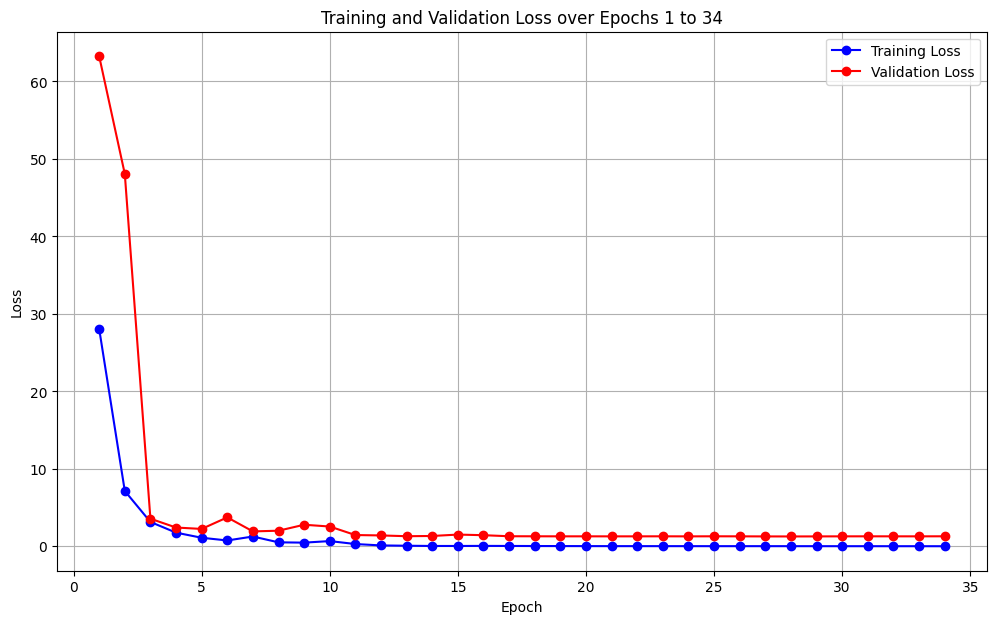

In [40]:
import matplotlib.pyplot as plt

# Données epochs 1 à 16
losses_1_16 = [28.07, 7.15, 3.15, 1.77, 1.11, 0.76, 1.27, 0.52, 0.48, 0.68, 0.30, 0.12, 0.08, 0.05, 0.05, 0.06]
val_losses_1_16 = [63.26, 48.07, 3.57, 2.43, 2.25, 3.74, 1.93, 2.02, 2.79, 2.56, 1.46, 1.41, 1.31, 1.34, 1.52, 1.44]
epochs_1_16 = list(range(1, len(losses_1_16) + 1))

# Données epochs 17 à 26
losses_17_26 = [0.0529, 0.0426, 0.0367, 0.0325, 0.0293, 0.0288, 0.0288, 0.0267, 0.0255, 0.0254]
val_losses_17_26 = [1.3055, 1.2996, 1.2935, 1.2941, 1.2907, 1.2919, 1.2972, 1.2892, 1.2990, 1.2932]
epochs_17_26 = list(range(17, 27))

# Données epochs 27 à 34
losses_27_34 = [0.0263, 0.0241, 0.0239, 0.0216, 0.0218, 0.0203, 0.0199, 0.0175]
val_losses_27_34 = [1.2834, 1.2786, 1.2847, 1.2923, 1.2957, 1.2939, 1.2925, 1.2996]
epochs_27_34 = list(range(27, 35))

# Fusionner toutes les listes pour courbe continue
losses = losses_1_16 + losses_17_26 + losses_27_34
val_losses = val_losses_1_16 + val_losses_17_26 + val_losses_27_34
epochs = epochs_1_16 + epochs_17_26 + epochs_27_34

plt.figure(figsize=(12,7))

plt.plot(epochs, losses, 'b-o', label='Training Loss')
plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs 1 to 34')
plt.legend()
plt.grid(True)
plt.show()